# Assignment 3

## Preamble

In [13]:
using Plots
using HypothesisTests
using DataFrames
using StatsBase
using LinearAlgebra
using Distributions
using Dates
using ForwardDiff
using Optim
include("marketdata_functions.jl")

cd("/home/rinto/Desktop/Macroeconometrics/Assignment 3")

## Function Definition

In [14]:
function VAR(y, p)
    T = size(y, 1)
    k = size(y, 2) 
    Y = y[p+1:end, :]
    X = [ones(T-p) [y[p + 1 - i:end - i, :] for i in 1:p]...]
    B̂ = inv(X'X)*X'Y
    ε̂ = Y - X*B̂
    Σ̂ = (ε̂'*ε̂)/(T - p)
    return B̂, Σ̂, ε̂
end

VAR(y::TimeArray, p) = VAR(values(y), p)


function likelihood(pars, y)
    # calculates the log-likelihood for only p = 1 lag
    T = size(y, 1) 
    ψ₀⁺= [pars[1] pars[3]; pars[4] pars[5]] 
    ψ₀⁻= [pars[2] pars[3]; pars[4] pars[5]] 
    c = [pars[6]; pars[7]]
    ψ₁ = [pars[8] pars[9]; pars[10] pars[11]]
    x = y[1:end-1, :]
    y = y[2:end, :]

    try
        L = 0.0
        for t in 1:T-1
            if y[t] > 0
                # log-likelihood function from expression derived in Q3
                L += log(det(ψ₀⁺)) - log(2*π) - 1/2 * (ψ₀⁺*y[t, :] - c - ψ₁*x[t, :])'*(ψ₀⁺*y[t, :] - c - ψ₁*x[t, :])
            else
                L += log(det(ψ₀⁻)) - log(2*π) - 1/2 * (ψ₀⁻*y[t, :] - c - ψ₁*x[t, :])'*(ψ₀⁻*y[t, :] - c - ψ₁*x[t, :])
            end
        end
        return L
    catch
        return -Inf
    end
end

likelihood(pars, y::TimeArray) = likelihood(pars, values(y))


function μΦ(B, k, p)
    μ = B[1, :]
    Φ = hcat([B[((i-1)*k:i*k - 1) .+ 2, :]' for i in 1:p]...)
    return μ, Φ
end;


function F(Φ, k, p)
    F = [Φ; 
         I(k*(p-1)) zeros(k*(p-1), k)]
    return F
end


function Cₛ(B̂, h)
    k = size(B̂, 2)
    p = (size(B̂, 1) - 1) ÷ k
    Φ̂ = μΦ(B̂, k, p)[2]
    FΦ̂ = F(Φ̂, k, p)
    #C = (FΦ̂^h)[1:k, 1:k]
    C = map(i -> (FΦ̂^i)[1:k, 1:k], h)
    return C
end


function SIRF(B̂, Σ̂, h)
    # obtain the h-step ahead reduced form responses
    C = Cₛ(B̂, h)
    # obtain lower triangular Choleski factor
    Θ̂₀ = cholesky(Σ̂).L
    # for each (i, j) collect [Θ̂ₕ]ᵢⱼ
    Θ̂ₕ = cat(map(c -> c*Θ̂₀, C)...; dims = 3)
    return Θ̂ₕ
end

SIRF (generic function with 1 method)

## Data Download

In [15]:
gdp = retrieve_marketdata(source = "fred", identifier = "A191RL1A225NBEA")
MarketData.rename!(gdp, :GDP)

surplus = retrieve_marketdata(source = "fred", identifier = "FYFSGDA188S")
MarketData.rename!(surplus, :SUR)

y = merge(gdp, surplus);

## Test Linearity

I first estimate the restricted maximum likelihood under the null hypothesis that $\hat{\Phi}_{0,11}^{+} = \hat{\Phi}_{0,11}^{-}$.

In [16]:
B̂, Σ̂, ε̂ = VAR(y, 1);

L₀̂  = 0.0;
p = 1;
T = size(y, 1);
for t in 1:T-p
    L₀̂ += -1/2 * (ε̂[t, :]' * inv(Σ̂) * ε̂[t, :]) - log(2*π) - 1/2 * log(det(Σ̂));
end 

L₀̂ 

-486.15367124040716

I estimate the unrestricted maximum likelihood, in which $\hat{\Phi}_{0,11}^{+} \neq \hat{\Phi}_{0,11}^{-}$.

In [17]:
# Set initial values
a = vec(inv(cholesky(Σ̂)));
init_pars = [a[1]; a[1:end]; rand(6)];

# Minimize function by calling optimize
# pars ordered as [ψ₀₁₁⁺, ψ₀₁₁⁻, ψ₀₁₂, ψ₀₂₁, ψ₀₂₂, c₁, c₂, ψ₁₁₁, ψ₁₁₂, ψ₁₂₁, ψ₁₂₂]
sol = optimize(pars -> -likelihood(pars, y), init_pars, BFGS(); autodiff = :forward)

L̂ = -sol.minimum

-483.98226147763455

I compute the LR statistic and its corresponding p-value following a $\chi^{2}$ distribution with 1 degree of freedom, since I am imposing only one restriction.

In [18]:
LR = 2 * (L̂ - L₀̂)

4.342819525545224

In [19]:
p = ccdf(Chisq(1), LR)

0.037165328403433444

I reject the null hypothesis that $\hat{\Phi}_{0,11}^{+} = \hat{\Phi}_{0,11}^{-}$ at a 5% confidence level. This implies $\Theta_{0}^{+} \neq \Theta_{0}^{-}$ given $\Theta_{0}^{\pm} = (\Phi_{0}^{\pm})^{-1}$, such that the SIRF is different depending on whether $y_{1t} >> 0$ or $y_{1t} << 0$. Therefore, this indicates a potential asymmetry in the fiscal multiplier. 

## Impulse Response

Next, I compute the SIRF under the null hypothesis that there is no asymmetry in the fiscal multiplier.

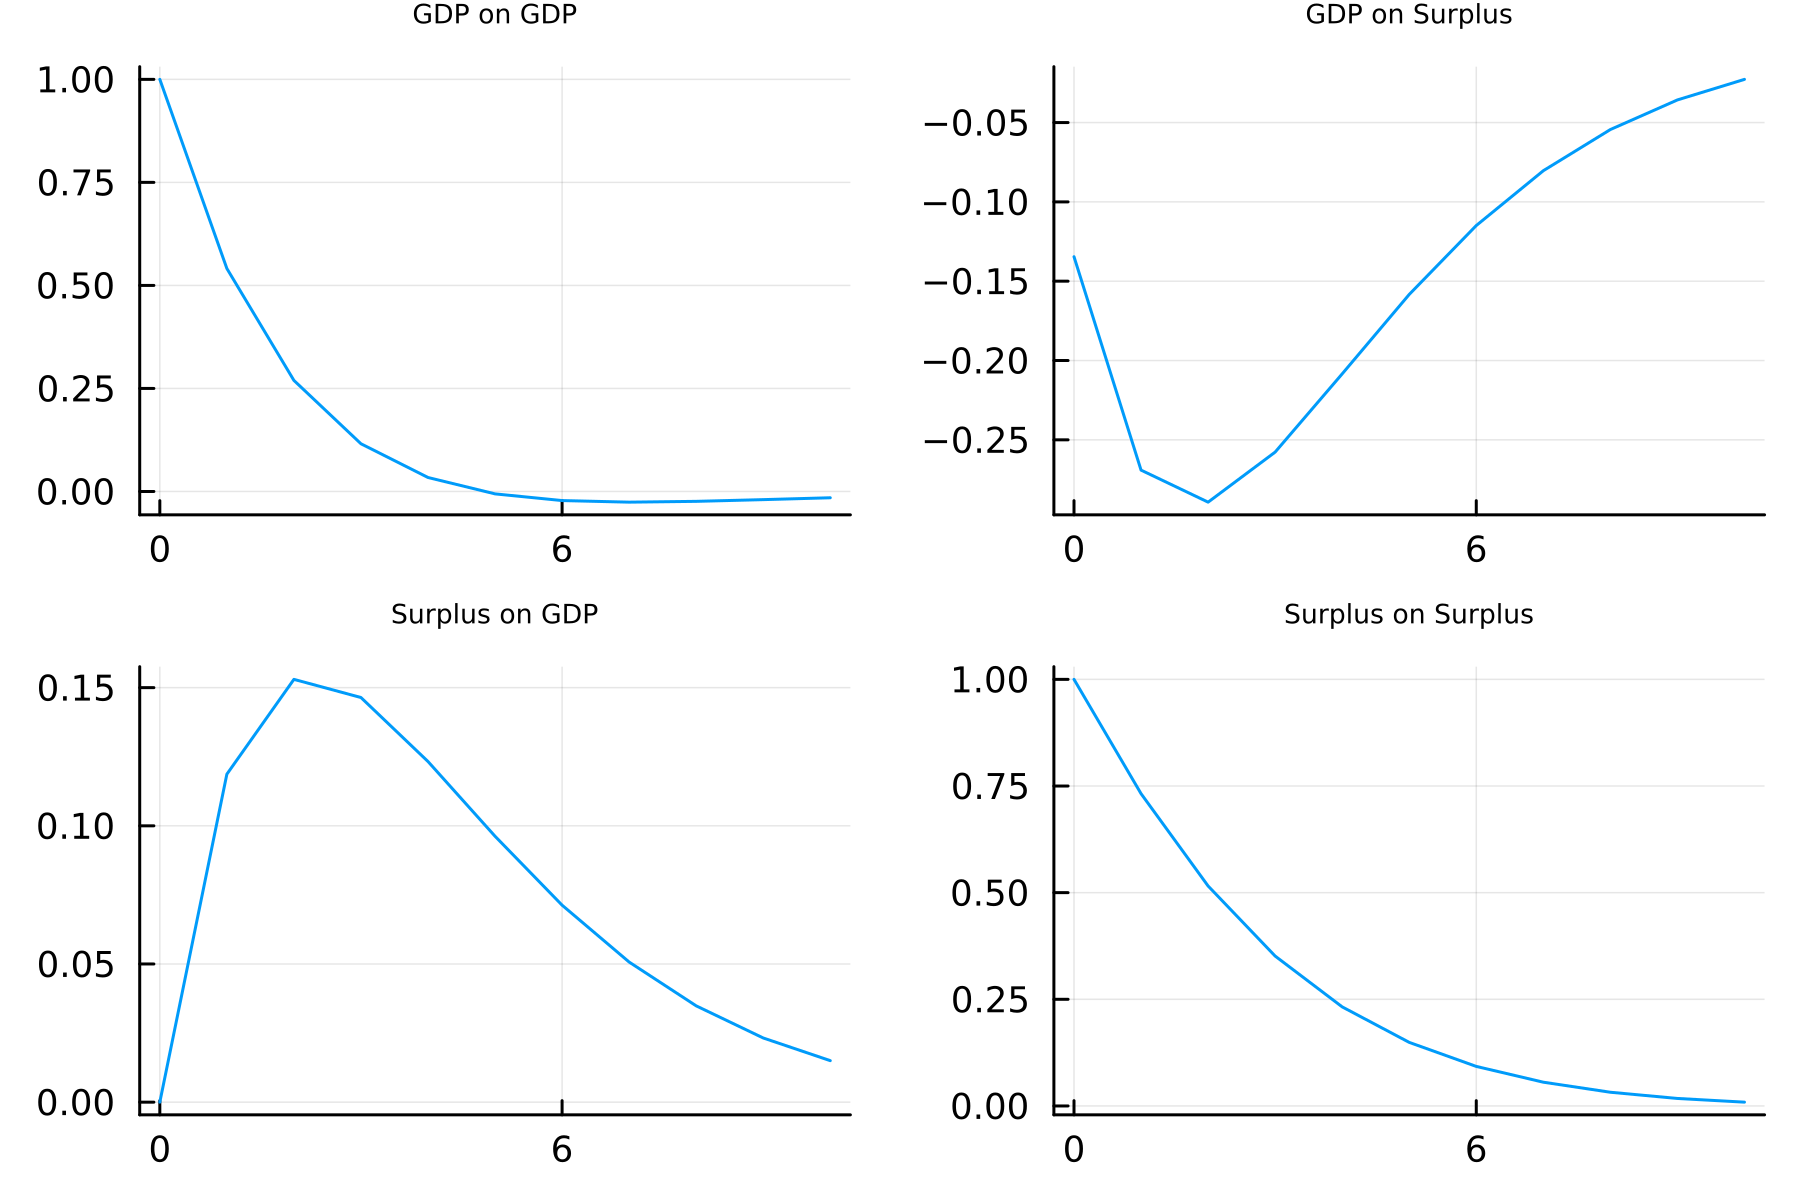

In [20]:
y = merge(gdp, surplus);
B̂, Σ̂, ε̂ = VAR(y, 1);

H = 0:10
Θ̂ = SIRF(B̂, Σ̂, H);

# normalise the size of the shocks
Θ̂[:, 1, :] =  Θ̂[:, 1, :] ./ Θ̂[1, 1, 1];
Θ̂[:, 2, :] =  Θ̂[:, 2, :] ./ Θ̂[2, 2, 1];

fig = plot(H, vec(eachslice(Θ̂; dims = (1,2))), layout = (2,2), legend = :none, 
title = permutedims([i*" on "*j for i in ["GDP", "Surplus"] for j in ["GDP", "Surplus"]]),
titlefontsize = 6, xticks = 0:6:60, dpi = 300)

The SIRF with recursive identification shows that a percentage point increase in real GDP growth leads to a decrease as large as 28 basis point in government surplus, while a one percentage point increase in government surplus leads to an increase as large as 15 basis points in real GDP growth. The estimators might be inconsistent with recursive identification since we would normally expect an increase in surplus (i.e. fiscal tightening) to have a negative impact on GDP and real GDP growth to have a positive impact on surplus.

I also compute the SIRF under the assumption of asymmetry in the effects of the fiscal multiplier, first in the scenario that GDP growth is positive.

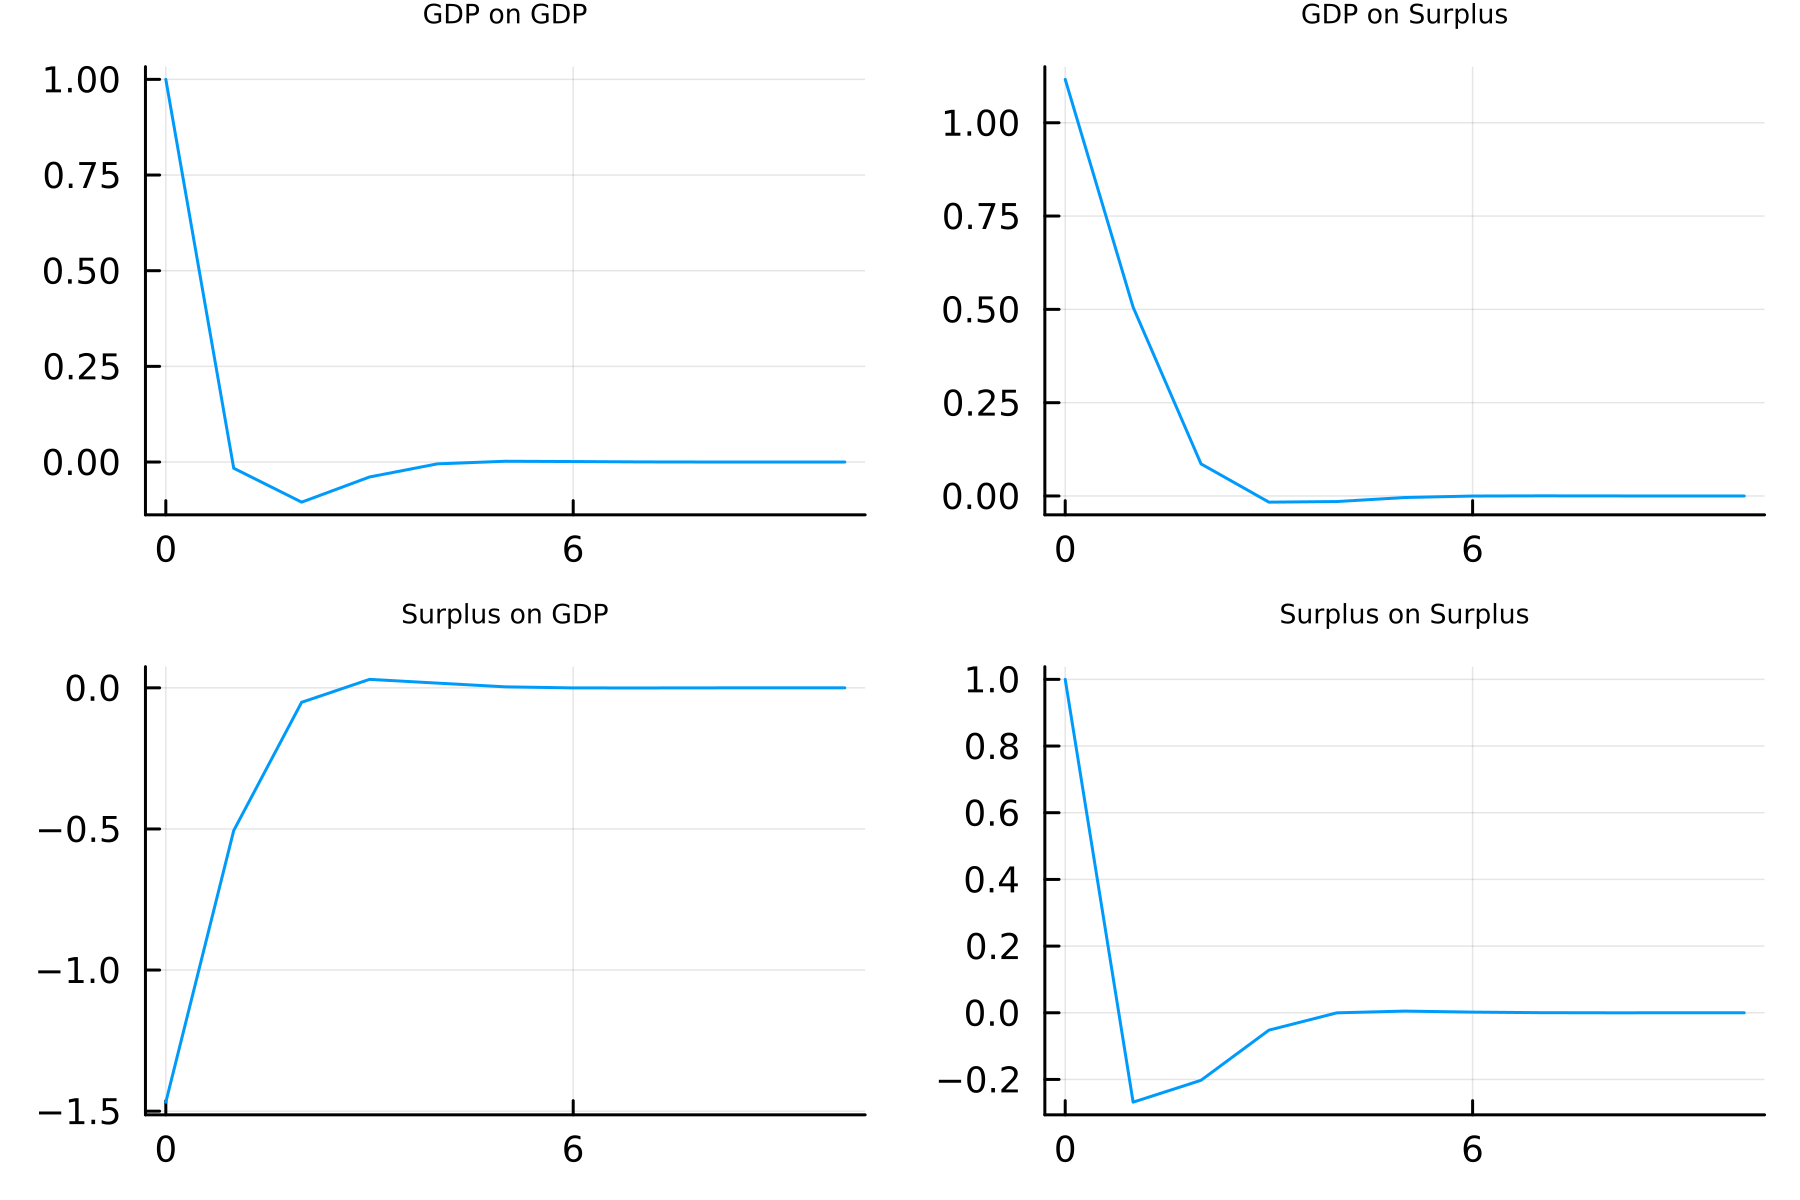

In [21]:
# ordered as [ψ₀₁₁⁺, ψ₀₁₁⁻, ψ₀₁₂, ψ₀₂₁, ψ₀₂₂, c₁, c₂, ψ₁₁₁, ψ₁₁₂, ψ₁₂₁, ψ₁₂₂]
ψ̂ = sol.minimizer
ĉ = [ψ̂[6] ψ̂[7]]
Ψ₀⁺̂ = [ψ̂[1] ψ̂[3]; ψ̂[4] ψ̂[5]]
Ψ₁̂ = [ψ̂[8] ψ̂[9]; ψ̂[10] ψ̂[11]]

# compute the SIRFS
B⁺̂ = vcat(ĉ, Ψ₀⁺̂)
Cₕ⁺̂ = Cₛ(B⁺̂ , H)
Θ₀⁺̂ = inv(Ψ₀⁺̂)
# unit-effect normalisation
Θ₀₁₁⁺̂ = Θ₀⁺̂[1, 1, 1];
Θ₀⁺̂[:, 1, :]  = Θ₀⁺̂[:, 1, :]  ./ Θ₀₁₁⁺̂ ;
Θ₀₂₂⁺̂ = Θ₀⁺̂[2, 2, 1];
Θ₀⁺̂[:, 2, :]  = Θ₀⁺̂[:, 2, :]  ./ Θ₀₂₂⁺̂ ;
Θₕ⁺̂ = cat(map(c -> c*Θ₀⁺̂ , Cₕ⁺̂ )...; dims = 3)

# Plot
fig = plot(H, vec(eachslice(Θₕ⁺̂; dims = (1,2))), layout = (2,2), legend = :none, 
title = permutedims([i*" on "*j for i in ["GDP", "Surplus"] for j in ["GDP", "Surplus"]]),
titlefontsize = 6, xticks = 0:6:60, dpi = 300)

I finally compute the SIRF under the scenario that GDP growth is negative.

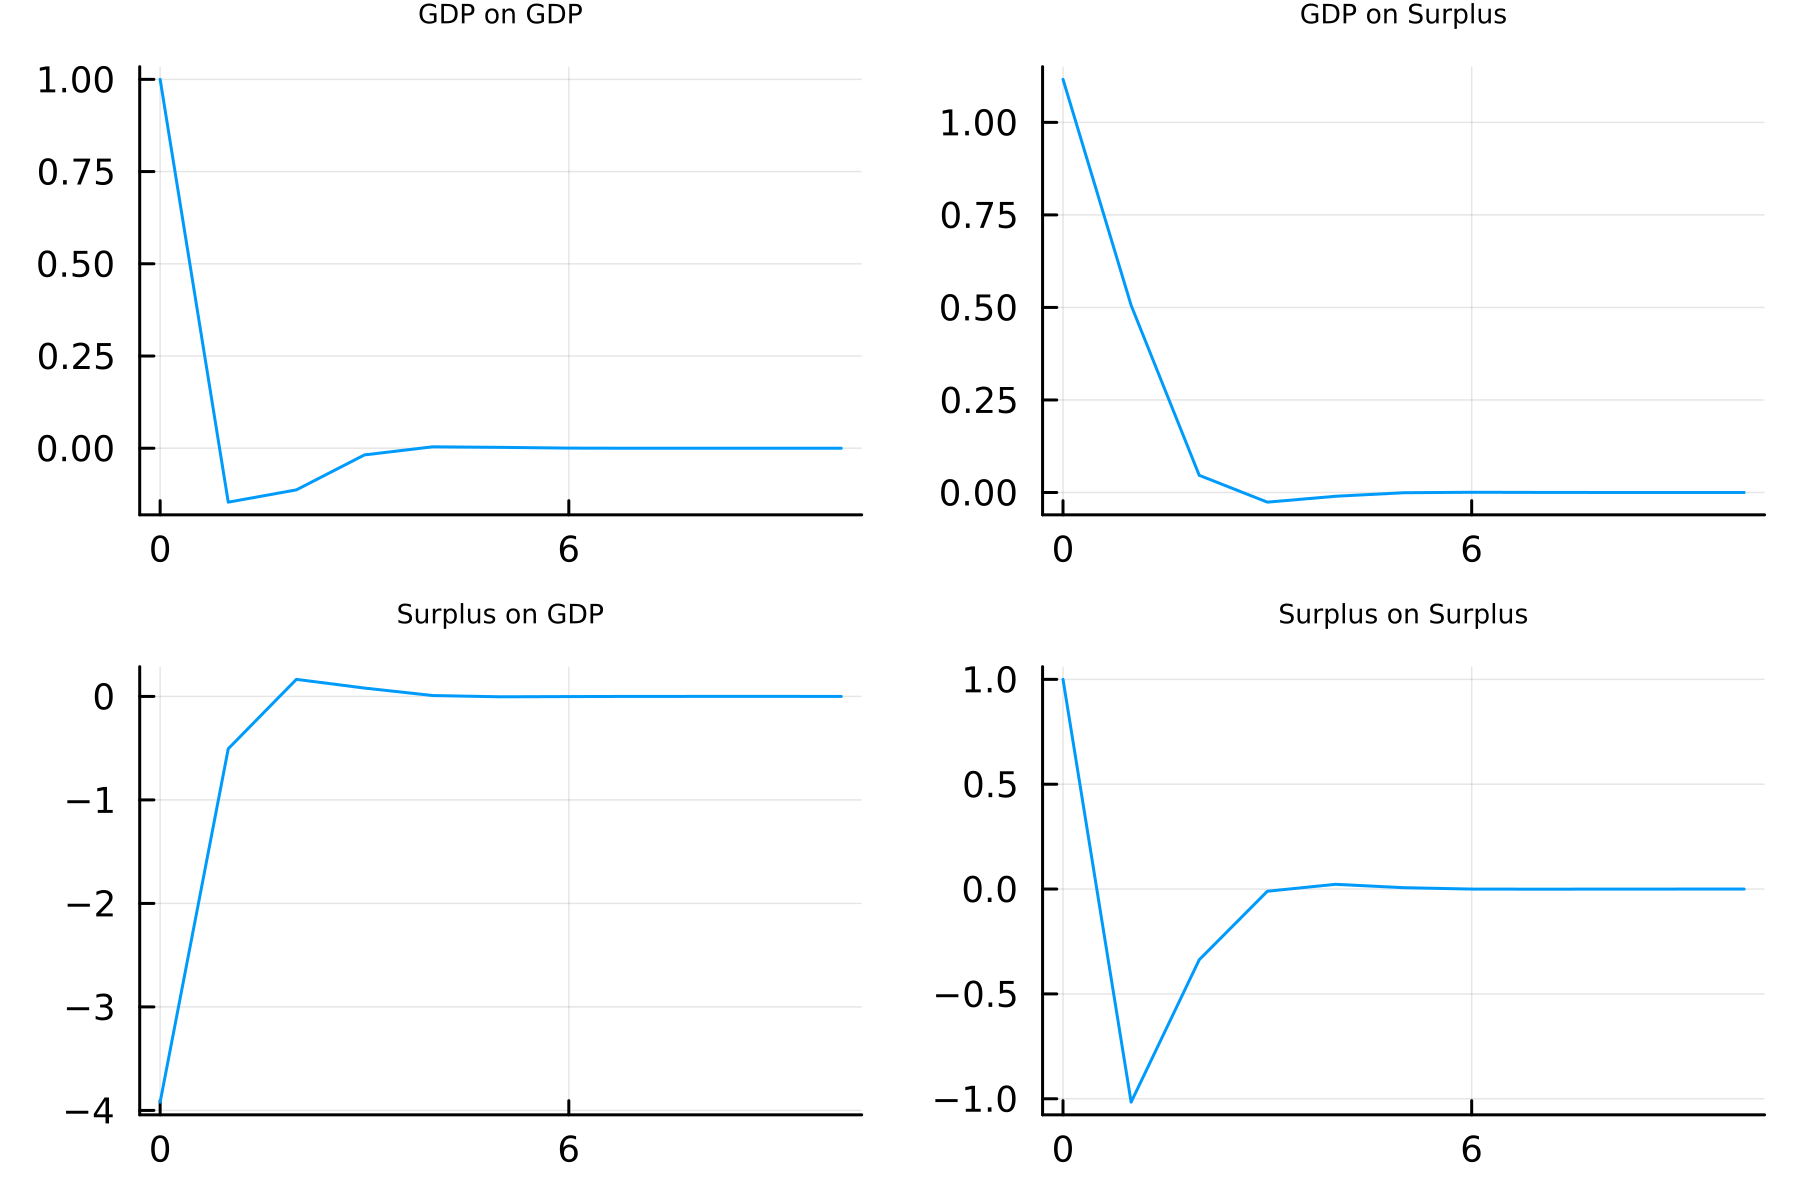

In [22]:
Ψ₀⁻̂ = [ψ̂[2] ψ̂[3]; ψ̂[4] ψ̂[5]]

# compute the SIRFS
B⁻̂ = vcat(ĉ, Ψ₀⁻̂)
Cₕ⁻̂ = Cₛ(B⁻̂, H)
Θ₀⁻̂ = inv(Ψ₀⁻̂)
# unit-effect normalisation
Θ₀₁₁⁻̂ = Θ₀⁻̂[1, 1, 1];
Θ₀⁻̂[:, 1, :]  = Θ₀⁻̂[:, 1, :]  ./ Θ₀₁₁⁻̂;
Θ₀₂₂⁻̂ = Θ₀⁻̂[2, 2, 1];
Θ₀⁻̂[:, 2, :]  = Θ₀⁻̂[:, 2, :]  ./ Θ₀₂₂⁻̂;
Θₕ⁻̂ = cat(map(c -> c*Θ₀⁻̂ , Cₕ⁻̂)...; dims = 3)

# Plot
fig = plot(H, vec(eachslice(Θₕ⁻̂;  dims = (1,2))), layout = (2,2), legend = :none, 
title = permutedims([i*" on "*j for i in ["GDP", "Surplus"] for j in ["GDP", "Surplus"]]),
titlefontsize = 6, xticks = 0:6:60, dpi = 300)

A positive GDP growth shock increases surplus while a positive surplus shock decreases GDP growth, as expected. Comparing the SIRF in the two regimes, we observe a clear difference between them. The fiscal multiplier is 1.5 times as large as the GDP growth shock in the positive regime, while it is 4 times as large in the negative regime. 

## Discussion

A potential threat to the model's internal validity is a lack of relevant variables in explaining the relationship between GDP growth and fiscal surplus (e.g. the degree of openness of the economy which might lead to leakage and a lower fiscal multiplier). Another threat to internal validity is the existence of more than two regimes, such that the size of the fiscal multiplier depends on more than two states of the world (e.g. it might depend on both growth and monetary policy). The first limitation can be addressed by adding more variables to the model, at the cost of efficiency. The second limitation can be addressed by allowing some parameters to take on more than two values, depending on the regime. 

Threats to the model's external validity include the number of countries studied, which includes only the United States. Most notably, the size of the fiscal multiplier is probably different between a small open economy and a large economy as leakage to foreign goods for a given fiscal stimulus is probably important in a small open economy. Secondly, while the sample used in this exercise covers a long period (1930-2023), the fiscal multiplier may be significantly different in other samples in periods of extreme inflation, war or natural disasters. To address those limitations, we should perform the same exercise on other samples, including smaller economies, countries with recurring periods of high inflation etc...